In [62]:
import osmnx as ox
import numpy as np
import srtm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [40]:
address = "Grand Place, Brussels, Belgium"
location_point = ox.geocode(address)
print("Coordinates:", location_point) 

distance = 1000  # meters
mode = "run"   # "gravel bike", "road bike", "run", "trail run"
if mode == "run" or mode == "trail":
    network_type = "walk"
else :
    network_type = "bike"

Coordinates: (50.8467291, 4.3524081)


In [41]:
# network_type -> “all”, “all_public”, “bike”, “drive”, “drive_service”, “walk”
# dist -> bounding box of size 2*dist around the point (a square)
G = ox.graph_from_point(location_point, dist=distance, network_type=network_type)

## Elevation data

In [42]:
elevation_data = srtm.get_data()
for node, data in G.nodes(data=True):
    lat = data['y']
    lon = data['x']
    elev = elevation_data.get_elevation(lat, lon)
    data['elevation'] = elev if elev is not None else 0

edge_elevations = []
for u, v, data in G.edges(data=True):
    elev_u = G.nodes[u].get('elevation', 0)
    elev_v = G.nodes[v].get('elevation', 0)
    data['elevation_gain'] = elev_v - elev_u
    edge_elevations.append(data['elevation_gain'])

In [55]:
def plot_graph_with_data(graph, data):
    # Normalize edge elevations for colormap
    norm = plt.Normalize(vmin=min(data), vmax=max(data))
    cmap = cm.get_cmap('terrain')
    edge_colors = cmap(norm(data))

    fig, ax = ox.plot_graph(
        graph,
        figsize=(8,8),
        node_size=0,
        node_color='blue',
        edge_color=edge_colors,
        edge_linewidth=1,
        bgcolor='white',
    )   
    return fig, ax

/var/folders/1n/0k3fgg594gqbvgbx1m7rz38c0000gn/T/ipykernel_73787/1055472331.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')


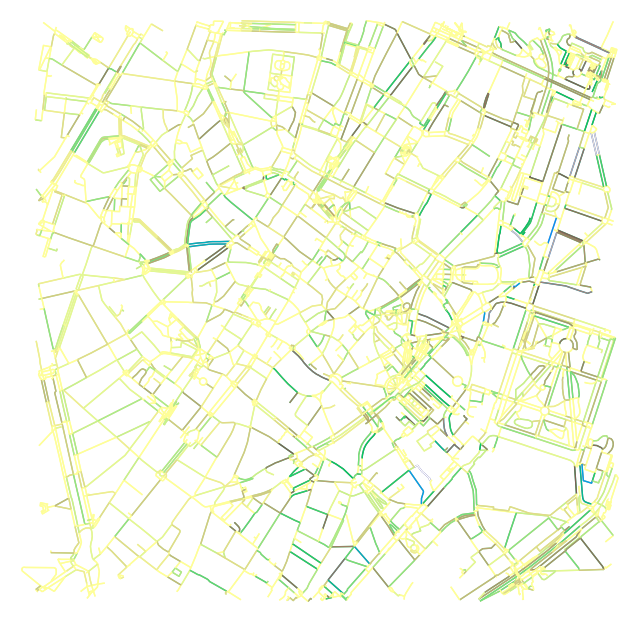

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [57]:
plot_graph_with_data(G, edge_elevations)

## Surface data

In [44]:
base_surface_scores = {
    "asphalt": 0.5,
    "paved": 0.5,
    "concrete": 0.5,
    "compacted": 0.5,
    "gravel": 0.5,
    "dirt": 0.5,
    "earth": 0.5,
    "sand": 0.5,
    "forest": 0.5,
    "grass": 0.5,
    "mud": 0.0,
    "wet_ground": 0.0,
    "unknown": 0.0,
}

mode_overrides = {
    "run": {},
    
    "trail_run": {
        "asphalt": 0.0,
        "paved": 0.0,
        "concrete": 0.0,
    },

    "road_bike": {
        "asphalt": 1.0,
        "paved": 1.0,
        "concrete": 1.0,
        "compacted": 0.0,
        "gravel": 0.0,
        "dirt": 0.0,
        "earth": 0.0,
        "sand": 0.0,
        "forest": 0.0,
        "grass": 0.0,
    },

    "gravel_bike": {
        "asphalt": 0.5,
        "paved": 0.5,
        "concrete": 0.5,
        "compacted": 0.5,
        "gravel": 0.5,
        "dirt": 0.5,
        "earth": 0.5,
        "sand": 0.0,
        "forest": 0.5,
        "grass": 0.5,
    },
}

base_scores_by_mode = {
    mode: {**base_surface_scores, **overrides}
    for mode, overrides in mode_overrides.items()
}

In [45]:
def update_surface_scores(mode, preference):

    scores = base_scores_by_mode[mode]

    preference_map = {
        "run": {
            "road": ["asphalt", "paved", "concrete"],
            "nature": ["dirt", "earth", "grass", "forest"],
            "sand": ["sand"],
        },
        "trail_run": {
            "forest": ["forest", "earth", "dirt"],
            "plain": ["grass", "sand", "earth"],
        },
        "gravel_bike": {
            "road": ["asphalt", "paved", "concrete"],
            "forest": ["forest", "earth", "dirt"],
            "plain": ["grass", "gravel", "compacted"],
        },
        # road_bike: no preference applied
    }

    # if road_bike or invalid preference → return base
    if mode not in preference_map or preference not in preference_map[mode]:
        return scores

    boosted = set(preference_map[mode][preference])
    for surface in scores:
        if surface in boosted:
            scores[surface] = 1.0

    return scores

In [67]:
preference = "nature"

surface_scores = update_surface_scores(mode, preference)
print(surface_scores)

edge_scores = []
for u, v, k, data in G.edges(keys=True, data=True):
    surface = data.get('surface', 'unknown')
    # if isinstance(surface, list):
    #     surface = surface[0]
    surface = str(surface).lower()
    score = surface_scores.get(surface, surface_scores.get('unknown', 0.0))
    data['surface_score'] = score
    edge_scores.append(score)

{'asphalt': 0.5, 'paved': 0.5, 'concrete': 0.5, 'compacted': 0.5, 'gravel': 0.5, 'dirt': 1.0, 'earth': 1.0, 'sand': 0.5, 'forest': 1.0, 'grass': 1.0, 'mud': 0.0, 'wet_ground': 0.0, 'unknown': 0.0}


/var/folders/1n/0k3fgg594gqbvgbx1m7rz38c0000gn/T/ipykernel_73787/1055472331.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')


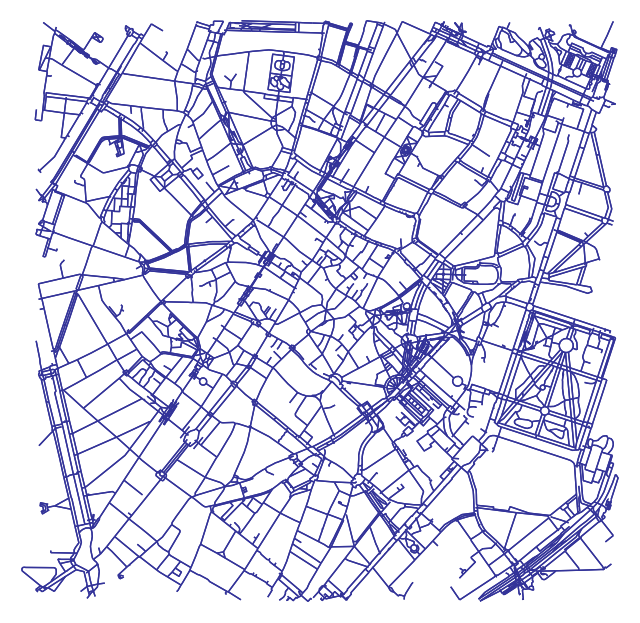

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [68]:
plot_graph_with_data(G, edge_scores)